In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
pd.options.display.max_columns = 100

/kaggle/input/mlbio1/train.csv
/kaggle/input/mlbio1/sample_submission.csv
/kaggle/input/mlbio1/test.csv


 # 1. EDA

### 1.1 Load data

In [2]:
sample = pd.read_csv('/kaggle/input/mlbio1/sample_submission.csv')
test = pd.read_csv('/kaggle/input/mlbio1/test.csv')
train = pd.read_csv('/kaggle/input/mlbio1/train.csv')

In [3]:
train.sample(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
26177,30628,Male,39.0,0,0,Yes,Private,Rural,97.50,27.3,smokes,0
6120,20058,Female,48.0,0,0,Yes,Self-employed,Rural,88.69,39.7,smokes,0
25238,43860,Male,61.0,0,0,Yes,Private,Urban,215.45,42.6,NaN,0
6980,36051,Female,65.0,1,0,Yes,Private,Urban,228.59,37.6,never smoked,0
4528,8037,Male,44.0,0,1,No,Govt_job,Urban,94.62,34.4,NaN,0


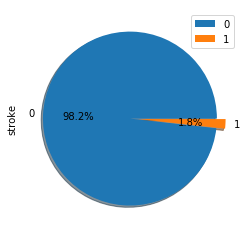

In [4]:
train["stroke"].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',shadow=True)
plt.legend()
plt.title('');

Classes are imbalanced

### 1.2 Working with missing values

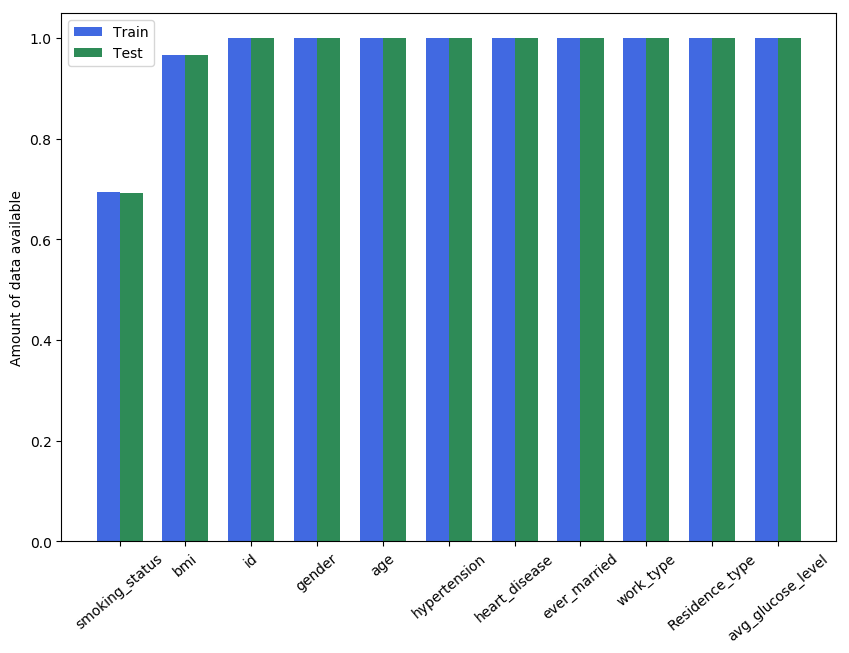

In [5]:
train_data = (train.count() / len(train)).drop("stroke").sort_values().values
ind = np.arange(len(train_data))
width = 0.35
fig, axes = plt.subplots(1,1,figsize=(10, 7), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = (test.count() / len(test)).sort_values().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Amount of data available');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels((train.count() / len(train)).sort_values().index, rotation=40)
axes.legend([tr, tt], ['Train', 'Test']);

In [6]:
#counts of nan
for i in train.columns:
    print(i, (pd.isnull(train[i])).sum() )
train[train['smoking_status'].isnull()== False]
train["smoking_status"].unique()

# fill with mean
mean_bmi = train['bmi'].mean()
train['bmi'] = train['bmi'].fillna(mean_bmi)
test['bmi'] = test['bmi'].fillna(mean_bmi)

train['smoking_status'] = train['smoking_status'].fillna('nan')
test['smoking_status'] = test['smoking_status'].fillna('nan')

id 0
gender 0
age 0
hypertension 0
heart_disease 0
ever_married 0
work_type 0
Residence_type 0
avg_glucose_level 0
bmi 1017
smoking_status 9176
stroke 0


### 1.3 Categorial data

In [7]:
train_d = pd.get_dummies(train)
test_d = pd.get_dummies(test)
all_feat = train_d.columns
train_d.sample(5)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_nan,smoking_status_never smoked,smoking_status_smokes
5998,45092,62.0,0,0,99.39,30.9,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0
29376,57201,39.0,0,0,224.47,26.7,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0
15445,8226,6.0,0,0,91.68,25.4,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0
11062,66999,27.0,0,0,91.45,30.2,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1
9778,1649,9.0,0,0,104.41,19.3,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0


### 1.4 Outliers

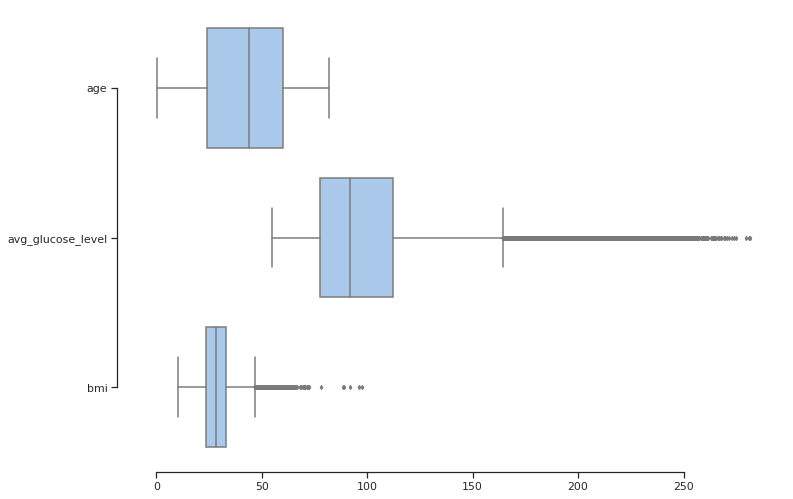

In [8]:
sns.set(style="ticks", palette="pastel",rc={'figure.figsize':(11.7,8.27)})
tips = train_d[["age","avg_glucose_level","bmi"]]

sns.boxplot(orient = "h", palette=["b"], data=tips, fliersize = 3)
sns.despine(offset=10, trim=True)

Outliers in "bmi" and "avg_glucose" are excluded (each value, which bigger than 2*the arithmetic mean)



In [9]:
train_no_outliers = train_d[train_d["bmi"]<2*train_d["bmi"].mean()]
train_no_outliers = train_no_outliers[train_no_outliers["avg_glucose_level"]<2*train_no_outliers["avg_glucose_level"].mean()]

# 2 Cross validation strategy

In [10]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

### ROC metric for binary classification with imbalanced classes

In [11]:
def my_cross_validation_for_roc_auc( clf, X, y ,cv=5):
    X = np.array(X.copy())
    y = np.array(y.copy())
    kf = KFold(n_splits=cv)
    kf.get_n_splits(X)
    scores = []
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X_train, y_train)
        prediction_on_this_fold = clf.predict_proba(X_test)[:,1]
        score = roc_auc_score(y_score=prediction_on_this_fold, y_true=y_test)
        scores.append(score)
    
    return scores

# 3 Feature analysis

### 3.1 Correlation Between The Features

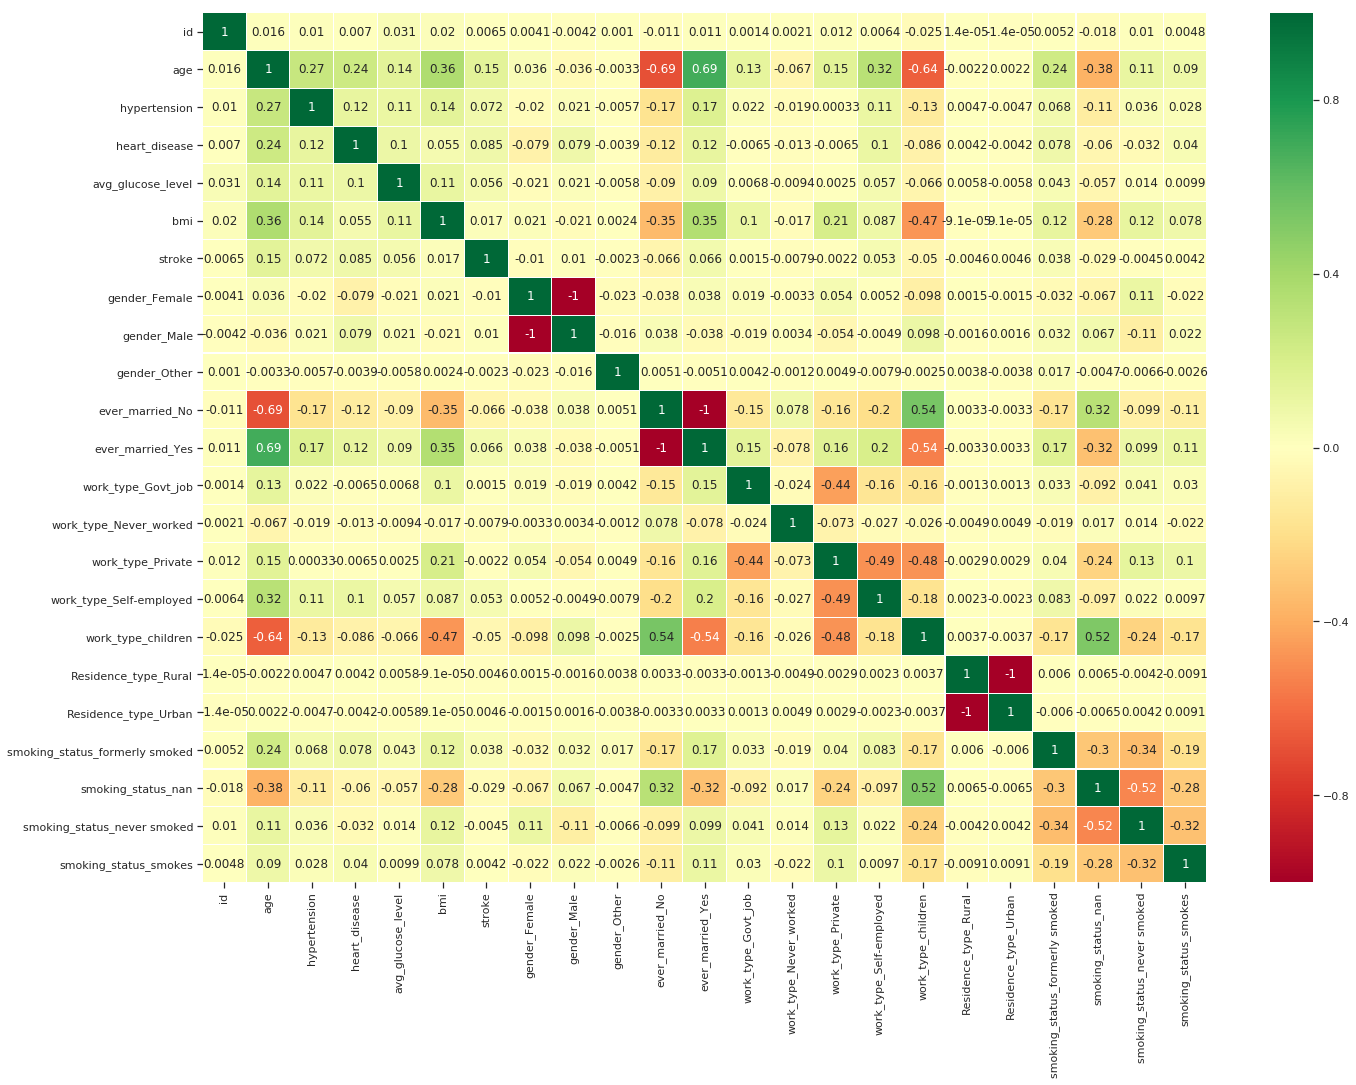

In [12]:
#all features
all_features = train_no_outliers.columns
sns.heatmap(train_no_outliers[all_features].corr(),annot=True,cmap='RdYlGn',linewidths=0.1)
fig=plt.gcf()
fig.set_size_inches(22.5,16)
plt.show()

### 3.2 Feature selection

In [13]:
lgb =   LGBMClassifier(n_estimators=185, max_depth=3,boosting_type='dart',
                       num_leaves=6,learning_rate=0.15,reg_lambda=0.46)
features_scores = {}
for f in all_features:
    scores = my_cross_validation_for_roc_auc(lgb, train_no_outliers[[f]] , train_no_outliers['stroke'])
    print(f,  np.mean(scores))
    features_scores[f] = np.mean(scores)

id 0.4952617689273383
age 0.8402815962592929
hypertension 0.5809088488953011
heart_disease 0.5680378189697567
avg_glucose_level 0.5687077398973193
bmi 0.6030585762441097
stroke 1.0
gender_Female 0.5136328687505408
gender_Male 0.5136328103720211
gender_Other 0.5
ever_married_No 0.6281026079431588
ever_married_Yes 0.6281026079431588
work_type_Govt_job 0.5089544556861216
work_type_Never_worked 0.4979674694159845
work_type_Private 0.5239171158901045
work_type_Self-employed 0.5762066933371766
work_type_children 0.572601178758118
Residence_type_Rural 0.504523394025284
Residence_type_Urban 0.504523394025284
smoking_status_formerly smoked 0.5578969872800652
smoking_status_nan 0.4818637179658721
smoking_status_never smoked 0.49155577224541636
smoking_status_smokes 0.4984176112267347


By Greedy algorithm 9 features were chosen (f3)

In [14]:
# final features
f3 = [ 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'ever_married_No', 'ever_married_Yes', 'work_type_Self-employed',
      'work_type_children']

# 4. Algorithms

### 4.1 Linear classifier with stochastic gradient descent and log-loss function 
SGDClassifier(max_iter=5000,  loss='log', penalty = 'l1')
#### It shows Public score = 0.85150
#### CV scores by fold 0.8062307247329275, 0.7490840031621402, 0.8063909708107497, 0.8094846798391414, 0.8381774540714938

### 4.2 LightGBM classifier with traditional Gradient Boosting Decision Tree
LGBMClassifier(n_estimators=100, max_depth=4)
#### It shows Public score = 0.86024
#### CV scores by fold 0.8482923097460542, 0.8525358384287318, 0.8578461989046974, 0.8444127652098369, 0.8442989601929999

### 4.3 LightGBM classifier with Dropouts meet Multiple Additive Regression Trees
LGBMClassifier(n_estimators=185, max_depth=3,boosting_type='dart',num_leaves=6,learning_rate=0.15,reg_lambda=0.46)
#### It shows Public score = 0.87502
#### CV scores by fold 0.8573062163538484, 0.8647515900122407, 0.8579354378082416, 0.8668245957359151, 0.8584210026934971

GBM Classifier from LightGBM library with boosting type ‘dart’(Dropouts meet Multiple Additive Regression Trees) shows the best score

In [15]:
lgb =   LGBMClassifier(n_estimators=185, max_depth=3,boosting_type='dart',
                       num_leaves=6,learning_rate=0.15,reg_lambda=0.46)
scores = my_cross_validation_for_roc_auc(lgb, train_no_outliers[f3] , train_no_outliers['stroke'])
print (scores, np.mean(scores))

[0.8573062163538484, 0.8647515900122407, 0.8579354378082416, 0.8668245957359151, 0.8584210026934971] 0.8610477685207485


### 4.4 CV score and Public Score

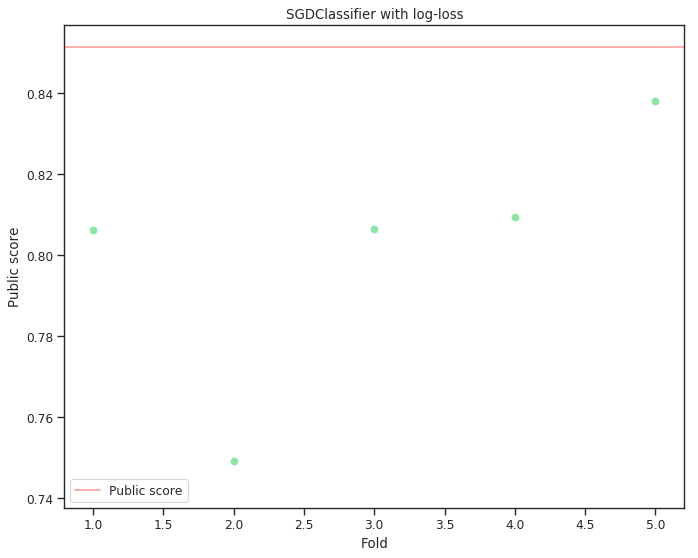

In [16]:
folds_pred = [0.8062307247329275, 0.7490840031621402, 0.8063909708107497, 0.8094846798391414, 0.8381774540714938]
folds = [1,2,3,4,5]
#d = {'Score': folds_pred, 'Fold': folds}
#df = pd.DataFrame(data=d)
plt.figure(figsize=(10,8), dpi= 80, facecolor='w', edgecolor='w')
plt.scatter(folds,folds_pred,color = 'g')
plt.axhline(y=0.85150, color='r', linestyle='-',label = "Public score")
plt.xlabel('Fold')
plt.ylabel('Public score')
plt.title('SGDClassifier with log-loss')
plt.legend()
plt.show()

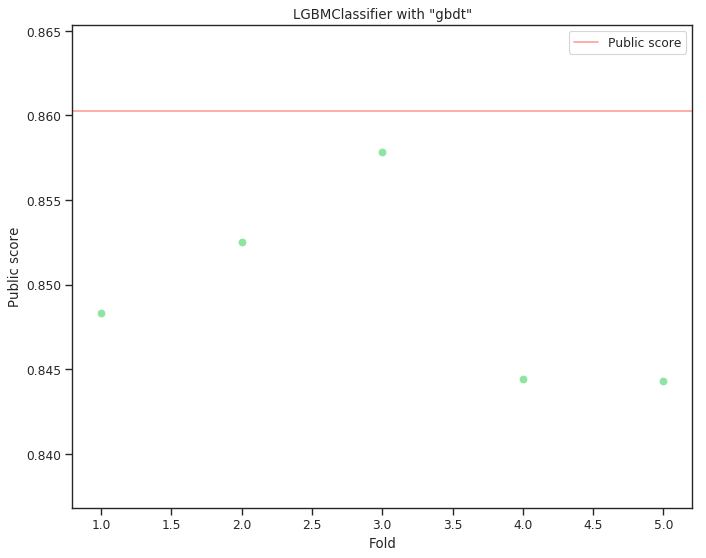

In [17]:
folds_pred = [0.8482923097460542, 0.8525358384287318, 0.8578461989046974, 0.8444127652098369, 0.8442989601929999]
folds = [1,2,3,4,5]
#d = {'Score': folds_pred, 'Fold': folds}
#df = pd.DataFrame(data=d)
plt.figure(figsize=(10,8), dpi= 80, facecolor='w', edgecolor='w')
plt.scatter(folds,folds_pred,color = 'g')
plt.axhline(y= 0.86024, color='r', linestyle='-',label = "Public score")
plt.xlabel('Fold')
plt.ylabel('Public score')
plt.title('LGBMClassifier with "gbdt"')
plt.legend()
plt.show()

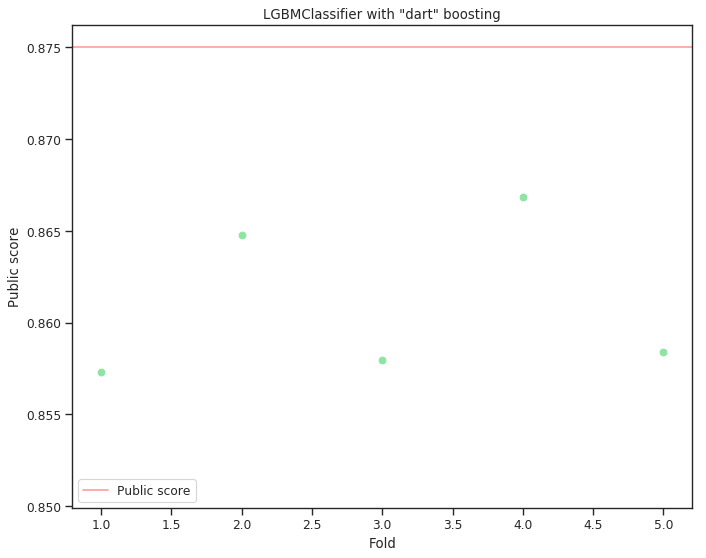

In [18]:
folds_pred = [0.8573062163538484, 0.8647515900122407, 0.8579354378082416, 0.8668245957359151, 0.8584210026934971]
folds = [1,2,3,4,5]
#d = {'Score': folds_pred, 'Fold': folds}
#df = pd.DataFrame(data=d)
plt.figure(figsize = (10, 8), dpi = 80, facecolor = 'w', edgecolor = 'w')
plt.scatter(folds,folds_pred,color = 'g')
plt.axhline(y = 0.87502, color = 'r', linestyle = '-',label = "Public score")
plt.xlabel('Fold')
plt.ylabel('Public score')
plt.title('LGBMClassifier with "dart" boosting')
plt.legend()
plt.show()

# 5. Fitting and Prediction

In [19]:
#train on all data
lgb.fit(train_no_outliers[f3] , train_no_outliers['stroke'])
#make predictin
prediction = lgb.predict_proba(test_d[f3])[:,1]
sample['stroke'] = prediction

### 5.1 Feature importance

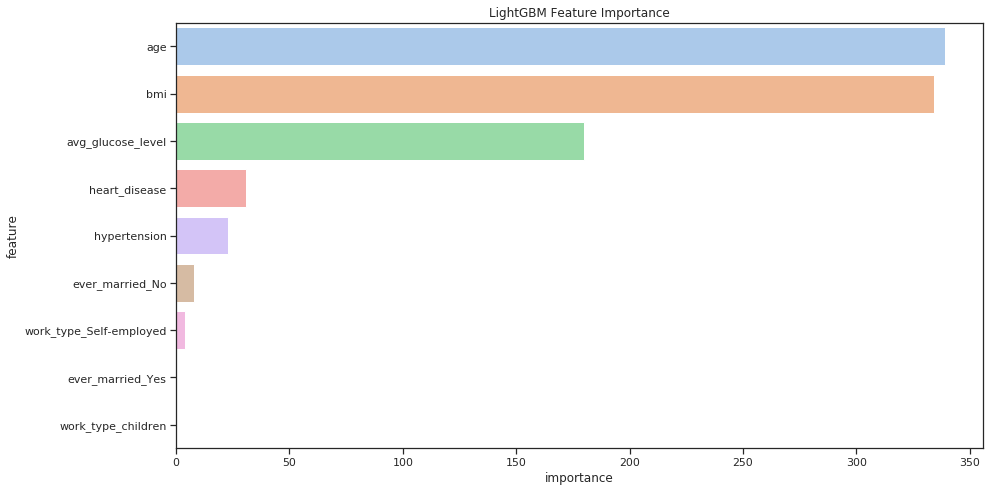

In [20]:
df_fimp = pd.DataFrame()
df_fimp["feature"] = train_no_outliers[f3].columns.values
df_fimp["importance"] = lgb.feature_importances_
plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

"bmi" and "age" has significant importance in LGBMClassifier model

### 5.2 Make submission

In [21]:
sample.to_csv('submi4.csv', index = None )